In [1]:
import sys
# sys.path.append('/content/ML_Forex_Forecasting')
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.tools import diff
import pickle
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Load the Data

In [2]:
usd_eur = pd.read_csv("./USDEUR=X.csv", parse_dates=['Date'])
usd_eur = usd_eur[['Date', 'Close']]

gold_prices = pd.read_csv("./GC=F.csv", parse_dates=['Date'])
gold_prices = gold_prices[['Date', 'Close']]
gold_prices.rename(columns = {'Close':'Gold_Price'}, inplace = True)

GSPC = pd.read_csv("./GSPC.csv", parse_dates=['Date'])
GSPC = GSPC[['Date', 'Close']]
GSPC.rename(columns = {'Close':'GSPC'}, inplace = True)

S50 = pd.read_csv("./STOXX50E.csv", parse_dates=['Date'])
S50 = S50[['Date', 'Close']]
S50.rename(columns = {'Close':'S50'}, inplace = True)

usd_eur = usd_eur.merge(gold_prices, on='Date')
usd_eur = usd_eur.merge(S50, on='Date')
usd_eur = usd_eur.merge(GSPC, on='Date')

print(f"USD/EUR: {usd_eur.shape}")
display(usd_eur)

USD/EUR: (247, 5)


,Date,Close,Gold_Price,S50,GSPC
0,2022-12-09,0.94700,1798.099976,3942.620117,3934.379883
1,2022-12-12,0.95037,1780.500000,3921.820068,3990.560059
2,2022-12-13,0.94861,1813.900024,3986.830078,4019.649902
3,2022-12-14,0.94103,1807.500000,3975.260010,3995.320068
4,2022-12-15,0.93665,1777.199951,3835.699951,3895.750000
...,...,...,...,...,...
242,2023-12-04,0.91843,2024.099976,4414.950195,4569.779785
243,2023-12-05,0.92270,2018.500000,4452.770020,4567.180176
244,2023-12-06,0.92647,2030.500000,4483.259766,4549.339844
245,2023-12-07,0.92879,2029.900024,4473.770020,4585.589844


# Dickey-Fuller Test

In [3]:
def dickey_fuller_test(df,var):
    result = adfuller(df[var].values)
    #Extracting the values from the results:
    print(f"Dickey-Fuller test for feature: {var}")

    print('Test Statistic: %f' % result[0])

    print('p-value: %f' % result[1])

    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]["5%"]:
        print ("Reject H0 - Time Series is Stationary")
    else:
        print ("Failed to Reject H0 - Time Series is Non-Stationary")

In [4]:
dickey_fuller_test(usd_eur,'Close')
print("")
dickey_fuller_test(usd_eur,'Gold_Price')
print("")
dickey_fuller_test(usd_eur,'S50')
print("")
dickey_fuller_test(usd_eur,'GSPC')

Dickey-Fuller test for feature: Close
Test Statistic: -2.642299
p-value: 0.084566
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to Reject H0 - Time Series is Non-Stationary

Dickey-Fuller test for feature: Gold_Price
Test Statistic: -3.472660
p-value: 0.008718
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Reject H0 - Time Series is Stationary

Dickey-Fuller test for feature: S50
Test Statistic: -2.258688
p-value: 0.185638
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to Reject H0 - Time Series is Non-Stationary

Dickey-Fuller test for feature: GSPC
Test Statistic: -1.083844
p-value: 0.721471
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to Reject H0 - Time Series is Non-Stationary


In [5]:
# Perform differencing
diff_data = diff(usd_eur.set_index('Date'), k_diff=1)

In [6]:
dickey_fuller_test(diff_data,'Close')
print("")
dickey_fuller_test(diff_data,'Gold_Price')
print("")
dickey_fuller_test(diff_data,'S50')
print("")
dickey_fuller_test(diff_data,'GSPC')

Dickey-Fuller test for feature: Close
Test Statistic: -16.422649
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Reject H0 - Time Series is Stationary

Dickey-Fuller test for feature: Gold_Price
Test Statistic: -4.960768
p-value: 0.000027
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Reject H0 - Time Series is Stationary

Dickey-Fuller test for feature: S50
Test Statistic: -16.572959
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Reject H0 - Time Series is Stationary

Dickey-Fuller test for feature: GSPC
Test Statistic: -15.087179
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Reject H0 - Time Series is Stationary


# Granger Causality Test

In [7]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, maxlag = 15, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [8]:
grangers_causation_matrix(diff_data, usd_eur.columns[1:])

,Close_x,Gold_Price_x,S50_x,GSPC_x
Close_y,1.0000,0.0000,0.0020,0.0000
Gold_Price_y,0.0489,1.0000,0.2257,0.0137
S50_y,0.0614,0.0364,1.0000,0.0002
GSPC_y,0.0785,0.0318,0.4071,1.0000


# ACF and PACF plots

In [9]:
def plot_autocorrelograms(df,var):
    plot_acf(df[var].dropna(),lags=20)
    plt.title(f"Autocorrelation for {var}")
    plot_pacf(df[var].dropna(),lags=20)
    plt.title(f"Partial Autocorrelation for {var}")

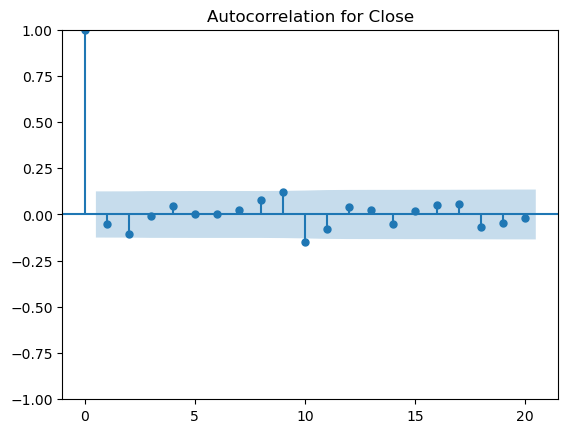

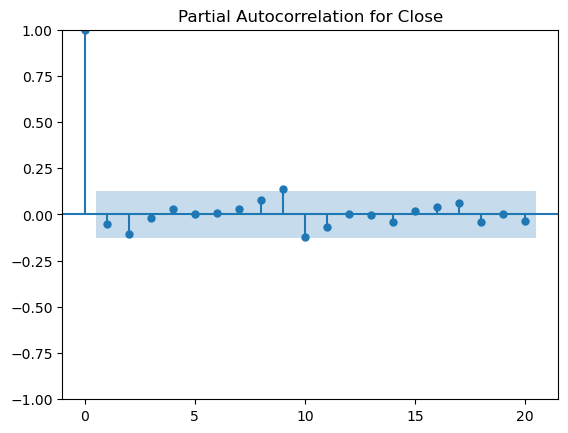

In [10]:
plot_autocorrelograms(diff_data,'Close')

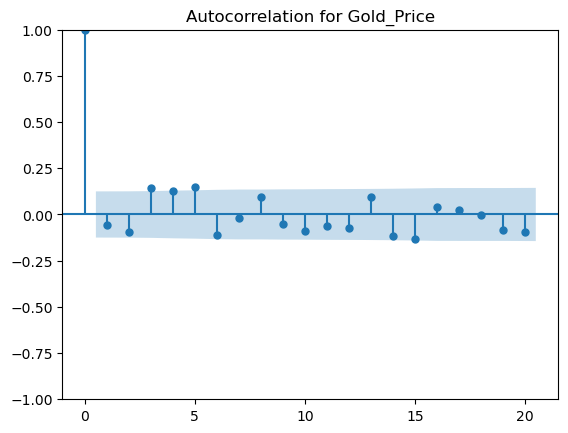

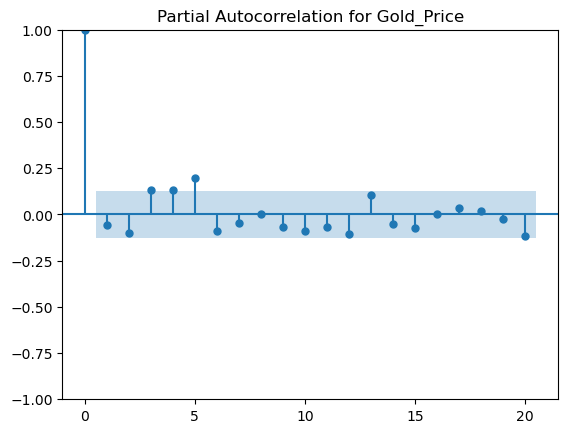

In [11]:
plot_autocorrelograms(diff_data,'Gold_Price')

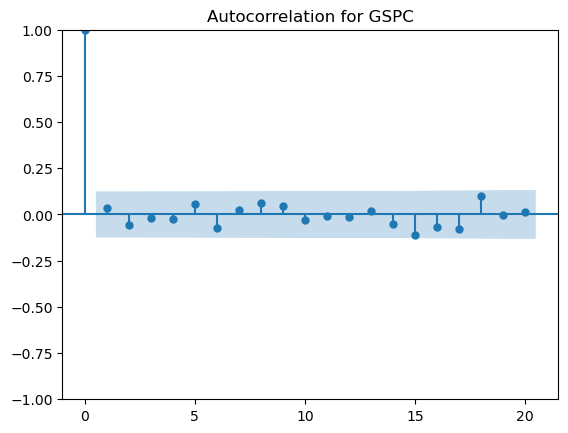

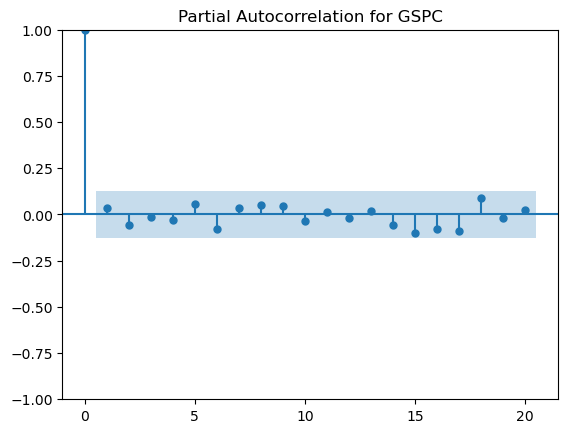

In [12]:
plot_autocorrelograms(diff_data,'GSPC')

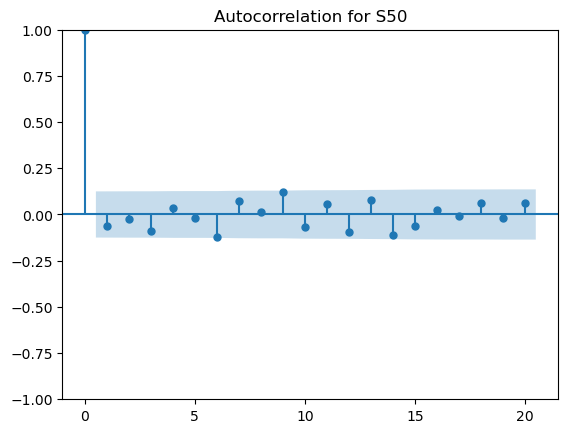

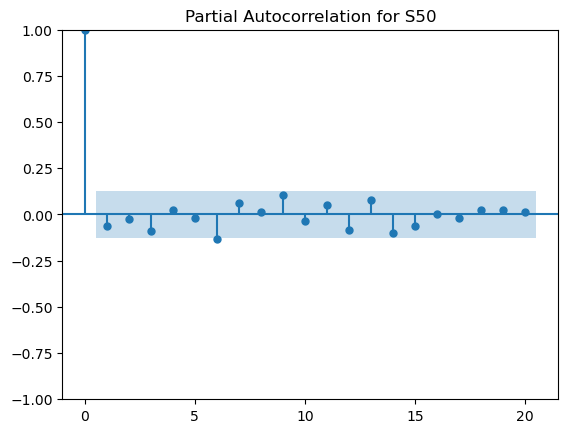

In [13]:
plot_autocorrelograms(diff_data,'S50')

# Model Training

In [14]:
data = usd_eur.copy()
df = data.dropna()

train, test = df[:-5], df[-5:]

data = train[['Close','Gold_Price','S50','GSPC']]

diff_data = diff(data, k_diff=1)
diff_test = diff(df[-6:], k_diff=1)


p = np.arange(1,11)
q = np.arange(1,11)
models = []
orders = []
MSEs = []
for i in p:
    for j in q:
        orders.append((i,j))
        model = VARMAX(endog=diff_data[['Close','Gold_Price']], order=(i,j), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse', exog=diff_data[['S50','GSPC']])
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['S50','GSPC']]).reset_index(drop=True).Close)
        pred['observed'] = test.reset_index(drop=True).Close
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))

/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models

In [15]:
idx = np.argmin(MSEs)
print(orders[idx])
model_fit = models[idx]

(1, 1)


/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


Text(0.5, 1.0, 'MSE = 0.00014322153702343087')

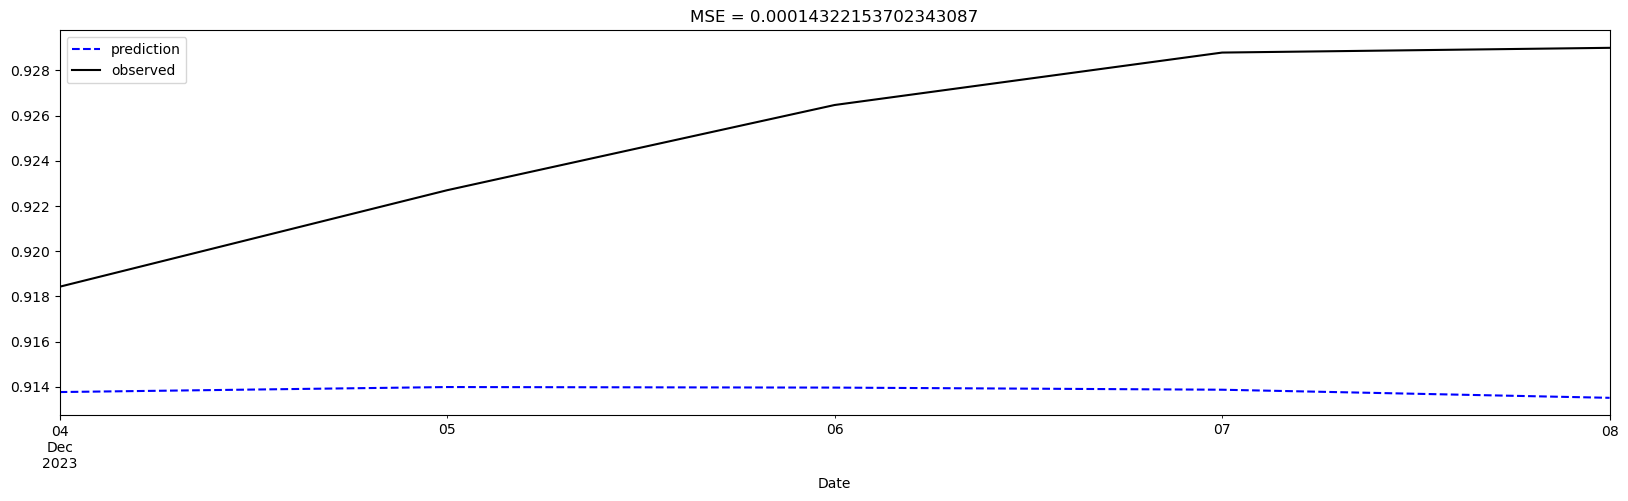

In [19]:
# plot prediction vs observed
pred = pd.DataFrame()
pred['prediction'] = data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['S50','GSPC']]).reset_index(drop=True).Close)
pred['observed'] = test.reset_index(drop=True).Close
pred['Date'] = test['Date'].reset_index(drop=True)

pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'], x='Date')
plt.title(f"MSE = {np.mean((pred['prediction'].values-pred['observed'].values)**2)}")

In [ ]:
print(pred)

   prediction  observed       Date
0    0.913771   0.91843 2023-12-04
1    0.913992   0.92270 2023-12-05
2    0.913968   0.92647 2023-12-06
3    0.913874   0.92879 2023-12-07
4    0.913515   0.92900 2023-12-08


/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


Text(0.5, 1.0, 'MSE = 9.611025429243891e-05')

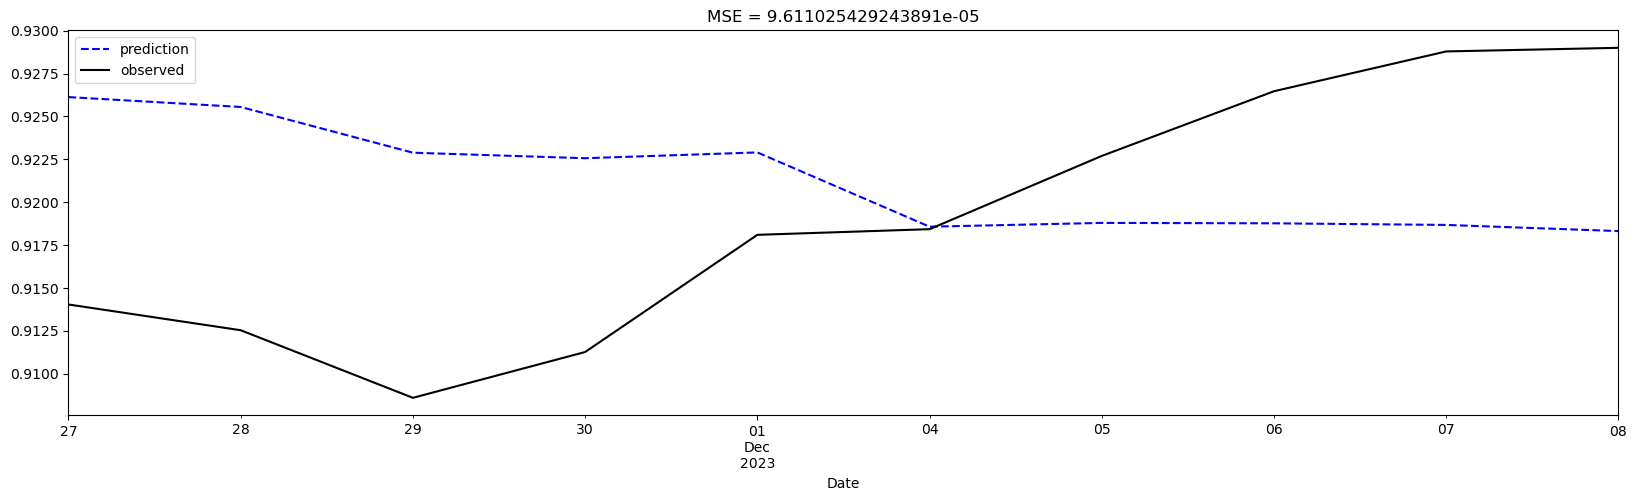

In [17]:
# plot prediction vs observed (last 2 weeks)
pred = pd.DataFrame()
temp = data.iloc[0]['Close'] + np.cumsum(model_fit.predict(start=0, end=diff_data.shape[0]+5-1, exog=diff_test[['S50','GSPC']]).Close)
pred['prediction'] = temp[-10:].reset_index(drop=True)
pred['observed'] = usd_eur.iloc[-10:]['Close'].reset_index(drop=True)
pred['Date'] = usd_eur.iloc[-10:]['Date'].reset_index(drop=True)

pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'], x='Date')
plt.title(f"MSE = {np.mean((pred['prediction'].values-pred['observed'].values)**2)}")

In [21]:
# Train all the data using the best p and q parameters
diff_data_all = diff(usd_eur[['Close','Gold_Price','S50','GSPC']], k_diff=1)
model = VARMAX(endog=diff_data_all[['Close','Gold_Price']], order=orders[idx], mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse', exog=diff_data_all[['S50','GSPC']])
model_fit_final = model.fit(disp=False)

/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
forecast_vals = usd_eur.iloc[-1]['Close'] + np.cumsum(model_fit_final.forecast(5, exog=diff_test[['S50','GSPC']]).reset_index(drop=True).Close)
print(forecast_vals)

0    0.932138
1    0.931599
2    0.931501
3    0.931493
4    0.931142
Name: Close, dtype: float64


/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [28]:
forecast_vals.values.tofile("./predictions_usdeur.csv", sep=',')

In [26]:
import pickle
pickle.dump(model_fit, open(f"./usd_eur_models/model_{orders[idx][0]}_{orders[idx][1]}_best.pkl","wb"))